In [44]:
import numpy as np
import pandas as pd

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import confusion_matrix, f1_score

import matplotlib.pyplot as plt


# Data Import and Feature Engineering

In [45]:
ticker = "AAPL"
dataSize = 2515

trainSize = 0.9


df = pd.read_csv(f"./data/{ticker}_{dataSize}.csv")
df = df.iloc[1:].reset_index(drop=True)
df = df[["Open","High","Low","Close"]].apply(pd.to_numeric, errors='coerce')
df.head()

,Open,High,Low,Close
0,27.839254,27.906165,27.455633,27.712124
1,27.886085,28.004294,27.698736,27.950766
2,27.761189,28.439217,27.729965,28.403530
3,28.468214,28.575270,28.097977,28.104668
4,28.068984,28.191654,27.872714,28.013226


In [46]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2515 entries, 0 to 2514
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Open    2515 non-null   float64
 1   High    2515 non-null   float64
 2   Low     2515 non-null   float64
 3   Close   2515 non-null   float64
dtypes: float64(4)
memory usage: 78.7 KB


In [47]:
split_idx = int(len(df) * trainSize)
train = df.iloc[:split_idx]
test = df.iloc[split_idx:]

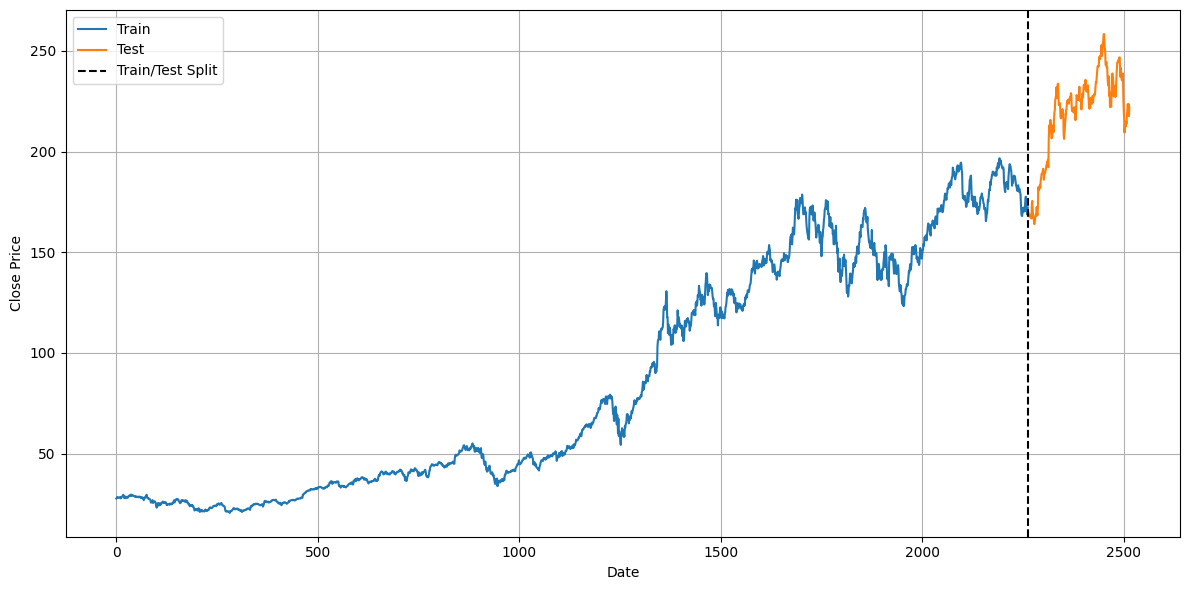

In [48]:
plt.figure(figsize=(12, 6))
plt.plot(train['Close'], label='Train')
plt.plot(test['Close'], label='Test')
plt.axvline(x=df.index[split_idx], color='black', linestyle='--', label='Train/Test Split')
plt.xlabel("Date")
plt.ylabel("Close Price")
plt.legend()
plt.tight_layout()
plt.grid(True)
plt.show()

## Feature Engineering

In [49]:
def compute_indicators(df, window):
    df = df.copy()
    
    # EMA (Exponential Moving Average)
    df[f'EMA_{window}'] = df['Close'].ewm(span=window, adjust=False).mean()
    df[f'EMA_{window*2}'] = df['Close'].ewm(span=window*2, adjust=False).mean()
    df[f'EMA_{window*4}'] = df['Close'].ewm(span=window*4, adjust=False).mean()
    df[f'EMA_{window*12}'] = df['Close'].ewm(span=window*12, adjust=False).mean()
    df[f'EMA_{window*24}'] = df['Close'].ewm(span=window*24, adjust=False).mean()
    
    # ROC (Rate of Change)
    df['ROC'] = df['Close'].pct_change(periods=window) * 100
    
    # RSI
    delta = df['Close'].diff()
    gain = delta.where(delta > 0, 0.0).rolling(window=window).mean()
    loss = -delta.where(delta < 0, 0.0).rolling(window=window).mean()
    rs = gain / (loss + 1e-6)
    df['RSI'] = 100 - (100 / (1 + rs))
    
    # ATR (Average True Range)
    tr = pd.concat([
        (df['High'] - df['Low']).abs(),
        (df['High'] - df['Close'].shift(1)).abs(),
        (df['Low'] - df['Close'].shift(1)).abs()
    ], axis=1).max(axis=1)
    df['ATR'] = tr.rolling(window=window).mean()

    df["Target"] = np.log(df["Close"].shift(-1) / df["Close"]) * 100
    # df["Target"] = df["Close"].shift(-1)

    df.dropna(inplace=True)
    
    return df

## Dataloader

In [50]:
class TimeSeriesDataset(Dataset):
    def __init__(self, data, seq_len):
        self.data = torch.tensor(data.values, dtype=torch.float32)
        self.seq_len = seq_len

    def __len__(self):
        return len(self.data) - self.seq_len

    def __getitem__(self, idx):
        x = self.data[idx : idx + self.seq_len, :-1]
        y = self.data[idx + self.seq_len - 1, -1]
        return x, y

# Models

In [51]:
class LSTM_Classic(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, dropout, output_dim):
        super(LSTM_Classic, self).__init__()
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True, dropout=dropout)
        self.relu = nn.ReLU()
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        x, _ = self.lstm(x)
        x = self.relu(x[:, -1, :]) # Use last hidden
        output = self.fc(x)
        return output

In [52]:
class CustomLSTM(nn.Module):
    def __init__(self, input_dim, hidden_dim):
        super(CustomLSTM, self).__init__()
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        
        # Combined weight matrices: W (input), U (hidden), and b
        self.W = nn.Parameter(torch.randn(4 * hidden_dim, input_dim))
        self.U = nn.Parameter(torch.randn(4 * hidden_dim, hidden_dim))
        self.b = nn.Parameter(torch.zeros(4 * hidden_dim))
        
    def forward(self, x, init_states=None):
        """
        x: (batch_size, seq_len, input_dim)
        init_states: (h_0, c_0) - each of shape (batch_size, hidden_dim)
        """
        batch_size, seq_len, _ = x.size()
        if init_states is None:
            h_t = torch.zeros(batch_size, self.hidden_dim, device=x.device)
            c_t = torch.zeros(batch_size, self.hidden_dim, device=x.device)
        else:
            h_t, c_t = init_states
        
        outputs = []
        for t in range(seq_len):
            x_t = x[:, t, :]  # (batch_size, input_dim)
            
            gates = x_t @ self.W.T + h_t @ self.U.T + self.b  # (batch_size, 4*hidden_dim)
            i_t, f_t, g_t, o_t = torch.chunk(gates, 4, dim=1)
            
            
            f_t = torch.sigmoid(f_t)

            # 1 - gate
            i_t = 1 - f_t

            g_t = torch.tanh(g_t)
            o_t = torch.sigmoid(o_t)
            
            c_t = f_t * c_t + i_t * g_t
            h_t = o_t * torch.tanh(c_t)
            
            outputs.append(h_t.unsqueeze(1))
        
        return torch.cat(outputs, dim=1), (h_t, c_t)

class LSTM_Var(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, dropout, output_dim):
        super(LSTM_Var, self).__init__()
        self.lstm = CustomLSTM(input_dim, hidden_dim)
        self.relu = nn.ReLU()
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        x, _ = self.lstm(x)
        x = self.relu(x[:, -1, :]) # Use last hidden
        output = self.fc(x)
        return output

In [103]:
class AttentionLayer(nn.Module):
    def __init__(self, hidden_dim):
        super(AttentionLayer, self).__init__()
        self.attn = nn.Linear(hidden_dim, 1)

    def forward(self, x):
        # x: (batch_size, seq_len, hidden_dim)
        weights = self.attn(x).squeeze(-1)           # (batch_size, seq_len)
        weights = F.softmax(weights, dim=1)          # attention weights α_t
        context = torch.bmm(weights.unsqueeze(1), x) # (batch_size, 1, hidden_dim)
        return context.squeeze(1)                    # (batch_size, hidden_dim)

class AttentionLSTM(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, dropout):
        super(AttentionLSTM, self).__init__()
        self.lstm = nn.LSTM(input_dim, hidden_dim, batch_first=True)
        self.dropout = nn.Dropout(dropout)
        self.attention = AttentionLayer(hidden_dim)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        lstm_out, _ = self.lstm(x)  # (batch_size, seq_len, hidden_dim)
        lstm_out = self.dropout(lstm_out)
        context = self.attention(lstm_out)  # (batch_size, hidden_dim)
        out = self.fc(context)              # (batch_size, output_dim)
        return out


# Helper Methods

In [54]:
def calc_metrics(true, pred):
    correct = ((pred >= 0) & (true >= 0)) | ((pred < 0) & (true < 0))
    accuracy = correct.sum() / len(correct)
    print(f"Directional Accuracy: {accuracy:.4f}")

    pred_labels = (pred >= 0).astype(int)
    true_labels = (true >= 0).astype(int)

    # Compute confusion matrix
    tn, fp, fn, tp = confusion_matrix(true_labels, pred_labels).ravel()

    print(f"Confusion Matrix:")
    print(f"True Positive  (TP): {tp}")
    print(f"True Negative  (TN): {tn}")
    print(f"False Positive (FP): {fp}")
    print(f"False Negative (FN): {fn}")

    f1 = f1_score(true_labels, pred_labels)
    print(f"F1 Score: {f1:.4f}")

In [55]:
def scale_features_keep_target(df, scaler=None):
    X = df.iloc[:, :-1]
    y = df.iloc[:, -1]
    if scaler is None:
        scaler = MinMaxScaler()
        X_scaled = scaler.fit_transform(X)
    else:
        X_scaled = scaler.transform(X)
    df_scaled = pd.DataFrame(X_scaled, columns=X.columns, index=df.index)
    df_scaled["Target"] = y.values
    return df_scaled, scaler

def scale_all_columns(df, scaler=None):
    if scaler is None:
        scaler = MinMaxScaler()
        scaled = scaler.fit_transform(df)
    else:
        scaled = scaler.transform(df)
        
    df_scaled = pd.DataFrame(scaled, columns=df.columns, index=df.index)
    return df_scaled, scaler

In [56]:
def train_model(model_class, train_df, input_dim, hidden_dim, output_dim,
                num_layers, dropout, learning_rate, num_epochs,
                batch_size, scale_features, regularization,
                seq_size, window_size, splits, device):
    
    cv_time = TimeSeriesSplit(n_splits=splits)
    criterion = nn.MSELoss()

    for fold, (train_idx, val_idx) in enumerate(cv_time.split(train_df)):

        # Model Selection
        if model_class == "Classic":
            model = LSTM_Classic(input_dim, hidden_dim, num_layers, dropout, output_dim).to(device)
        elif model_class == "Variant":
            model = LSTM_Var(input_dim, hidden_dim, num_layers, dropout, output_dim).to(device)
        elif model_class == "Attention":
            model = AttentionLSTM(input_dim, hidden_dim, output_dim, dropout).to(device)
        else:
            print("No model type found")
            return
        

        if regularization:
            optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-5)
        else:
            optimizer = optim.Adam(model.parameters(), lr=learning_rate)

        raw_train = train.iloc[train_idx].copy()
        raw_val = train.iloc[val_idx].copy()

        print(f"Running Fold {fold+1} with train size {len(raw_train)} and val size {len(raw_val)}.")

        train_feat = compute_indicators(raw_train, window_size)
        val_feat = compute_indicators(raw_val, window_size)

        if scale_features:
            train_feat, scaler = scale_features_keep_target(train_feat)
            val_feat, _        = scale_features_keep_target(val_feat, scaler)

            # train_feat, scaler = scale_all_columns(compute_indicators(train_feat, WINDOW_SIZE))
            # val_feat, _ = scale_all_columns(compute_indicators(val_feat, WINDOW_SIZE), scaler)


        

        trainDataset = TimeSeriesDataset(train_feat, seq_len=seq_size)
        valDataset = TimeSeriesDataset(val_feat, seq_len=seq_size)

        trainLoader = DataLoader(trainDataset, batch_size, shuffle=False)
        valLoader = DataLoader(valDataset, batch_size, shuffle=False)

        for epoch in range(num_epochs):
            # Train
            model.train()
            epoch_loss = 0
            for X_train, y_train in trainLoader:
                X_train = X_train.to(device)
                y_train = y_train.to(device)
                # print(X_train.shape)
                optimizer.zero_grad()
                output = model(X_train)  # Last day in seq
                loss = criterion(output.squeeze(), y_train)
                loss.backward()
                optimizer.step()
                epoch_loss += loss.item()

            # Val
            model.eval()
            val_pred = []
            val_true = []
            val_loss = 0
            with torch.no_grad():
                for X_val, y_val in valLoader:
                    X_val = X_val.to(device)
                    y_val = y_val.to(device)
                    output = model(X_val)
                    loss = criterion(output.squeeze(-1), y_val)
                    val_loss += loss.item()

                    val_pred.extend(output.to('cpu').numpy())
                    val_true.extend(y_val.to('cpu').numpy())


            val_pred = np.array(val_pred)
            val_true = np.array(val_true)
        

            if ((epoch+1) % (num_epochs/5) == 0):
                print(f"Epoch {epoch+1:4d} | Train MSE: {epoch_loss:.4f} | Val MSE: {val_loss:.4f}")

        print("Evaluation on Validation")
        calc_metrics(val_true, val_pred)

    return model

# Results

In [57]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


## Classic LSTM

### Tuning

In [58]:
# input_dim = 12
# hidden_dim = 64
# num_layers = 2
# output_dim = 1
# dropout = 0.4
# num_epochs = 800
# learning_rate = 1e-3

# scale_features = True
# regularization = True

In [59]:
input_dim = 12
hidden_dim = 64

output_dim = 1
num_layers = 2
dropout = 0.4
learning_rate = 1e-3
num_epochs = 800
batch_size = 64
scale_features = True
regularization = True
seq_size = 7
window_size = 5
splits = 2

model = train_model("Classic", train, input_dim, hidden_dim, output_dim,
                num_layers, dropout, learning_rate, num_epochs,
                batch_size, scale_features, regularization,
                seq_size, window_size, splits, device)

Running Fold 1 with train size 755 and val size 754.
Epoch  160 | Train MSE: 23.4421 | Val MSE: 79.6881
Epoch  320 | Train MSE: 15.8999 | Val MSE: 99.9661
Epoch  480 | Train MSE: 13.4161 | Val MSE: 105.0924
Epoch  640 | Train MSE: 9.7810 | Val MSE: 105.5810
Epoch  800 | Train MSE: 6.3826 | Val MSE: 108.1293
Evaluation on Validation
Directional Accuracy: 360.8947
Confusion Matrix:
True Positive  (TP): 130
True Negative  (TN): 207
False Positive (FP): 131
False Negative (FN): 273
F1 Score: 0.3916
Running Fold 2 with train size 1509 and val size 754.
Epoch  160 | Train MSE: 84.3352 | Val MSE: 36.5183
Epoch  320 | Train MSE: 82.6531 | Val MSE: 55.8314
Epoch  480 | Train MSE: 69.4508 | Val MSE: 54.4593
Epoch  640 | Train MSE: 53.4136 | Val MSE: 70.9753
Epoch  800 | Train MSE: 43.2807 | Val MSE: 60.3099
Evaluation on Validation
Directional Accuracy: 368.0202
Confusion Matrix:
True Positive  (TP): 151
True Negative  (TN): 228
False Positive (FP): 132
False Negative (FN): 230
F1 Score: 0.4548


In [ ]:
train_feat = compute_indicators(train, window_size)
test_feat  = compute_indicators(test, window_size)

if scale_features:
    train_feat, scaler = scale_features_keep_target(train_feat)
    test_feat, _       = scale_features_keep_target(test_feat, scaler)

trainDataset = TimeSeriesDataset(train_feat, seq_len=seq_size)
testDataset = TimeSeriesDataset(test_feat, seq_len=seq_size)

trainLoader = DataLoader(trainDataset, batch_size=batch_size, shuffle=False)
testLoader = DataLoader(testDataset, batch_size=batch_size, shuffle=False)

### Train Results

In [80]:
model = LSTM_Classic(input_dim, hidden_dim, num_layers, dropout, output_dim).to(device)
criterion = nn.MSELoss()

if regularization:
    optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-5)
else:
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Train
model.train()
for epoch in range(num_epochs):
    epoch_loss = 0
    for X_train, y_train in trainLoader:
        X_train = X_train.to(device)
        y_train = y_train.to(device)
        # print(X_train.shape)
        optimizer.zero_grad()
        output = model(X_train)  # Last day in seq
        loss = criterion(output.squeeze(), y_train)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()

    if ((epoch+1) % (num_epochs/5) == 0):
        print(f"Epoch {epoch+1:4d} | Train MSE: {epoch_loss:.4f}")

# Evaluation
model.eval()
train_pred = []
train_true = []
val_loss = 0
with torch.no_grad():
    for X_train, y_train in trainLoader:
        X_train = X_train.to(device)
        y_train = y_train.to(device)
        output = model(X_train)
        loss = criterion(output.squeeze(-1), y_train)
        val_loss += loss.item()

        train_pred.extend(output.to('cpu').numpy())
        train_true.extend(y_train.to('cpu').numpy())


train_pred = np.array(train_pred)
train_true = np.array(train_true)


Epoch  160 | Train MSE: 115.0289
Epoch  320 | Train MSE: 89.9265
Epoch  480 | Train MSE: 62.0677
Epoch  640 | Train MSE: 43.8800
Epoch  800 | Train MSE: 34.3408


In [81]:
calc_metrics(train_true, train_pred)

Directional Accuracy: 1138.7653
Confusion Matrix:
True Positive  (TP): 1037
True Negative  (TN): 712
False Positive (FP): 355
False Negative (FN): 146
F1 Score: 0.8054


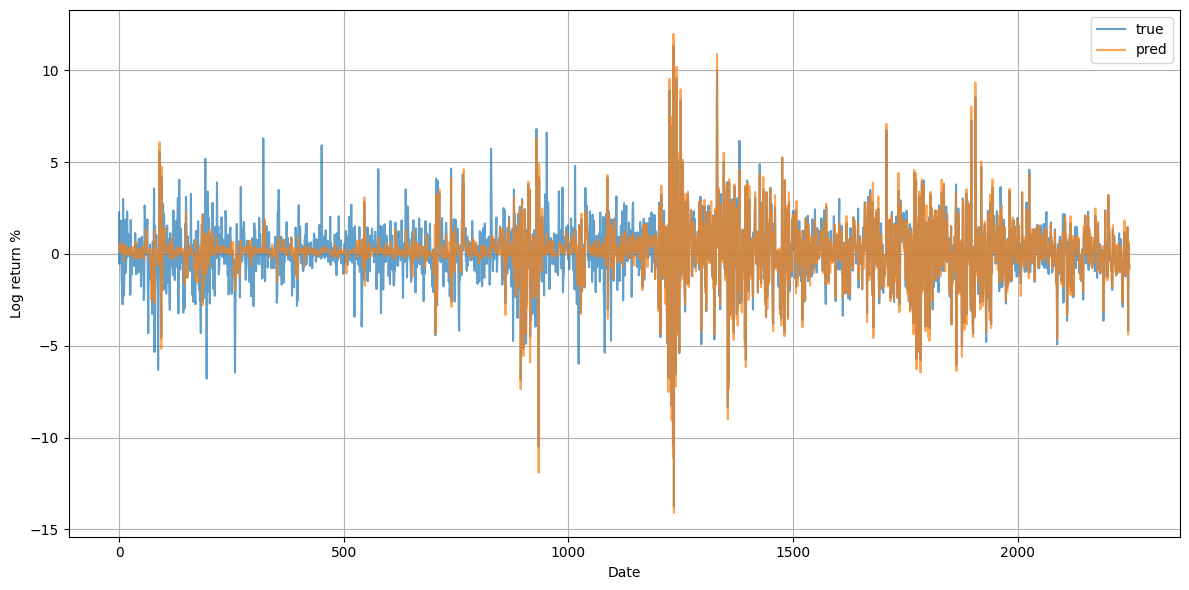

In [82]:
plt.figure(figsize=(12, 6))
plt.plot(train_true, label='true', alpha=0.7)
plt.plot(train_pred, label='pred', alpha=0.7)
plt.xlabel("Date")
plt.ylabel("Log return %")
plt.legend()
plt.tight_layout()
plt.grid(True)
plt.show()

### Test Results

Directional Accuracy: 0.4644
Confusion Matrix:
True Positive  (TP): 54
True Negative  (TN): 57
False Positive (FP): 41
False Negative (FN): 87
F1 Score: 0.4576


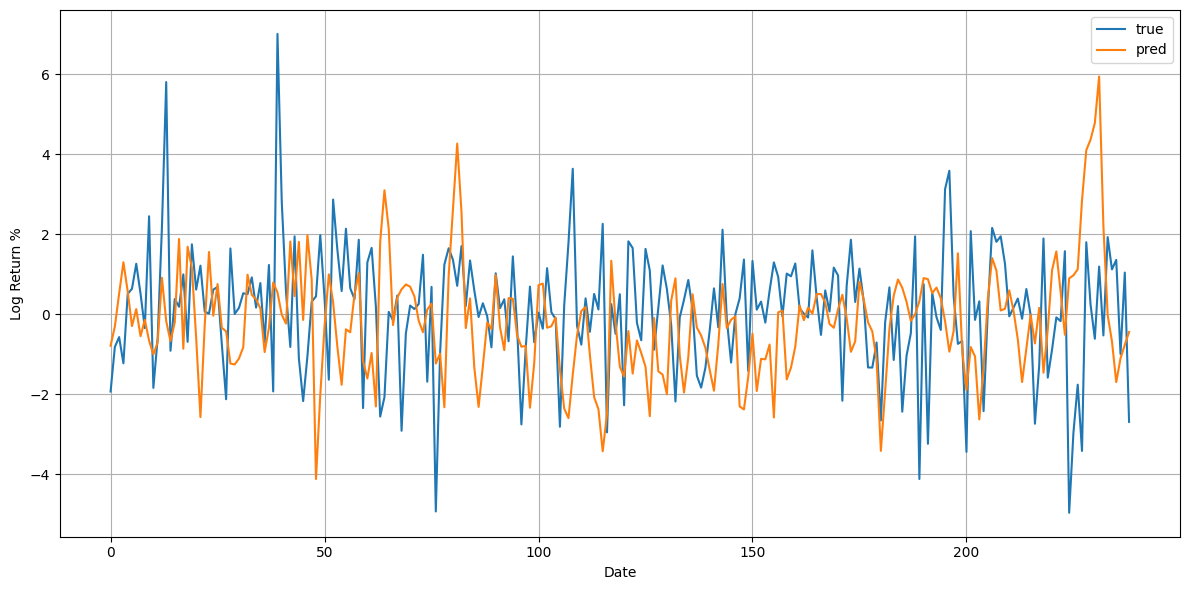

In [83]:
model.eval()
test_pred = []
test_true = []

with torch.no_grad():
    for X_test,y_test in testLoader:
        X_test = X_test.to(device)
        y_test = y_test.to(device)
        out = model(X_test).squeeze(-1)

        test_pred.extend(out.to('cpu').numpy())
        test_true.extend(y_test.to('cpu').numpy())


test_pred = np.array(test_pred)
test_true = np.array(test_true)

calc_metrics(test_true, test_pred)

plt.figure(figsize=(12, 6))
plt.plot(test_true, label='true')
plt.plot(test_pred, label='pred')
plt.xlabel("Date")
plt.ylabel("Log Return %")
plt.legend()
plt.tight_layout()
plt.grid(True)
plt.show()

## Variant LSTM

In [ ]:
# input_dim = 12
# hidden_dim = 64
# num_layers = 2
# output_dim = 1
# dropout = 0.4
# num_epochs = 800
# learning_rate = 1e-3

# scale_features = True
# regularization = True

In [67]:
input_dim = 12
hidden_dim = 64

output_dim = 1
num_layers = 2
dropout = 0.4
learning_rate = 1e-3
num_epochs = 800
batch_size = 64
scale_features = True
regularization = True
seq_size = 7
window_size = 5
splits = 2

model = train_model("Variant", train, input_dim, hidden_dim, output_dim,
                num_layers, dropout, learning_rate, num_epochs,
                batch_size, scale_features, regularization,
                seq_size, window_size, splits, device)

Running Fold 1 with train size 755 and val size 754.
Epoch  160 | Train MSE: 6.0398 | Val MSE: 67.8936
Epoch  320 | Train MSE: 2.1801 | Val MSE: 72.6295
Epoch  480 | Train MSE: 2.9085 | Val MSE: 71.8721
Epoch  640 | Train MSE: 0.2889 | Val MSE: 78.4529
Epoch  800 | Train MSE: 0.2427 | Val MSE: 78.0072
Evaluation on Validation
Directional Accuracy: 348.3509
Confusion Matrix:
True Positive  (TP): 78
True Negative  (TN): 298
False Positive (FP): 40
False Negative (FN): 325
F1 Score: 0.2994
Running Fold 2 with train size 1509 and val size 754.
Epoch  160 | Train MSE: 39.8001 | Val MSE: 52.1975
Epoch  320 | Train MSE: 21.4207 | Val MSE: 65.9047
Epoch  480 | Train MSE: 11.7533 | Val MSE: 64.2552
Epoch  640 | Train MSE: 15.2994 | Val MSE: 64.5548
Epoch  800 | Train MSE: 10.8812 | Val MSE: 61.3713
Evaluation on Validation
Directional Accuracy: 363.1174
Confusion Matrix:
True Positive  (TP): 57
True Negative  (TN): 307
False Positive (FP): 53
False Negative (FN): 324
F1 Score: 0.2322


In [69]:
train_feat = compute_indicators(train, window_size)
test_feat  = compute_indicators(test, window_size)

if scale_features:
    train_feat, scaler = scale_features_keep_target(train_feat)
    test_feat, _       = scale_features_keep_target(test_feat, scaler)

trainDataset = TimeSeriesDataset(train_feat, seq_len=seq_size)
testDataset = TimeSeriesDataset(test_feat, seq_len=seq_size)

trainLoader = DataLoader(trainDataset, batch_size=batch_size, shuffle=False)
testLoader = DataLoader(testDataset, batch_size=batch_size, shuffle=False)

### Train Results

In [84]:
model = LSTM_Var(input_dim, hidden_dim, num_layers, dropout, output_dim).to(device)
criterion = nn.MSELoss()

if regularization:
    optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-5)
else:
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Train
model.train()
for epoch in range(num_epochs):
    epoch_loss = 0
    for X_train, y_train in trainLoader:
        X_train = X_train.to(device)
        y_train = y_train.to(device)
        # print(X_train.shape)
        optimizer.zero_grad()
        output = model(X_train)  # Last day in seq
        loss = criterion(output.squeeze(), y_train)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()

    if ((epoch+1) % (num_epochs/5) == 0):
        print(f"Epoch {epoch+1:4d} | Train MSE: {epoch_loss:.4f}")

# Evaluation
model.eval()
train_pred = []
train_true = []
val_loss = 0
with torch.no_grad():
    for X_train, y_train in trainLoader:
        X_train = X_train.to(device)
        y_train = y_train.to(device)
        output = model(X_train)
        loss = criterion(output.squeeze(-1), y_train)
        val_loss += loss.item()

        train_pred.extend(output.to('cpu').numpy())
        train_true.extend(y_train.to('cpu').numpy())


train_pred = np.array(train_pred)
train_true = np.array(train_true)

Epoch  160 | Train MSE: 55.6241
Epoch  320 | Train MSE: 34.6247
Epoch  480 | Train MSE: 26.3685
Epoch  640 | Train MSE: 24.3393
Epoch  800 | Train MSE: 12.4116


In [85]:
calc_metrics(train_true, train_pred)

Directional Accuracy: 1131.2382
Confusion Matrix:
True Positive  (TP): 1050
True Negative  (TN): 871
False Positive (FP): 196
False Negative (FN): 133
F1 Score: 0.8646


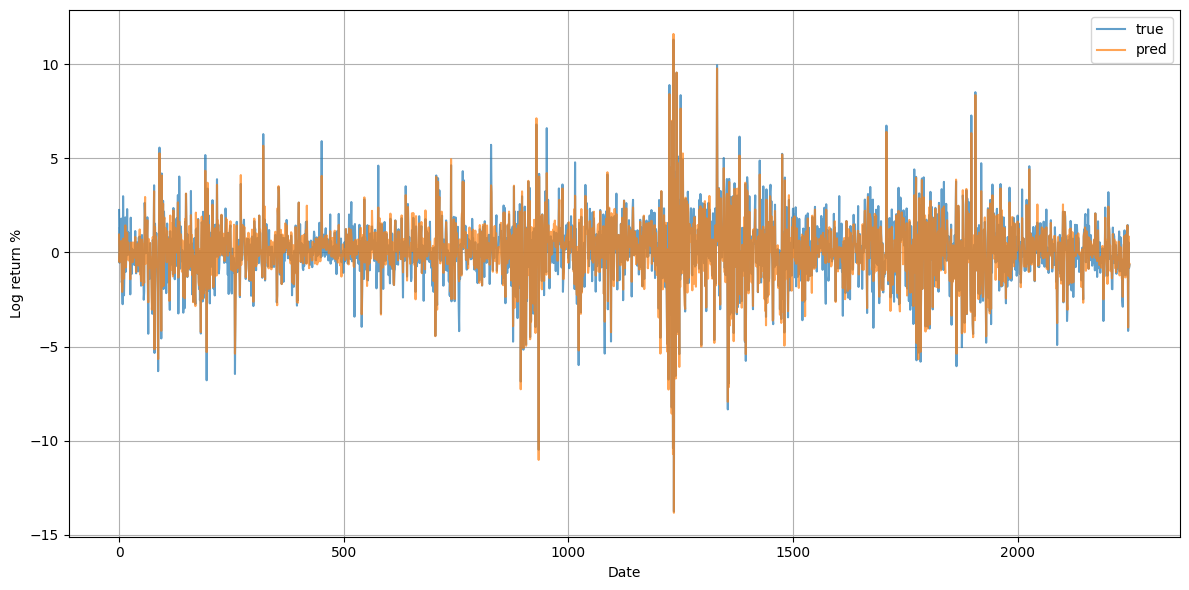

In [86]:
plt.figure(figsize=(12, 6))
plt.plot(train_true, label='true', alpha=0.7)
plt.plot(train_pred, label='pred', alpha=0.7)
plt.xlabel("Date")
plt.ylabel("Log return %")
plt.legend()
plt.tight_layout()
plt.grid(True)
plt.show()

### Test Results

Directional Accuracy: 0.4937
Confusion Matrix:
True Positive  (TP): 33
True Negative  (TN): 85
False Positive (FP): 13
False Negative (FN): 108
F1 Score: 0.3529


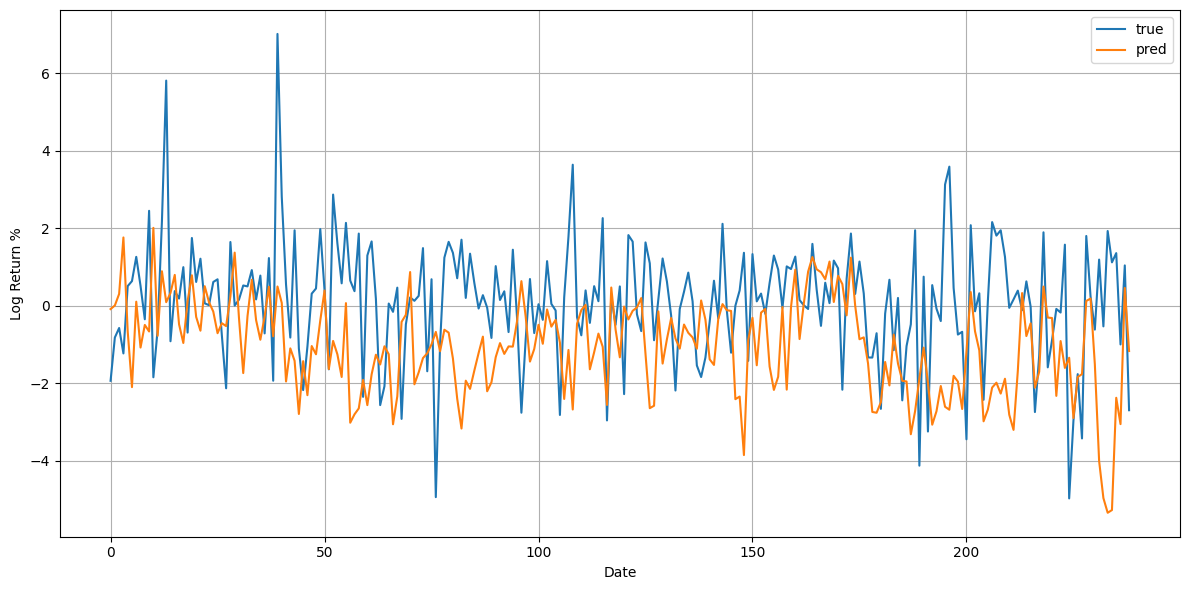

In [87]:
model.eval()
test_pred = []
test_true = []

with torch.no_grad():
    for X_test,y_test in testLoader:
        X_test = X_test.to(device)
        y_test = y_test.to(device)
        out = model(X_test).squeeze(-1)

        test_pred.extend(out.to('cpu').numpy())
        test_true.extend(y_test.to('cpu').numpy())


test_pred = np.array(test_pred)
test_true = np.array(test_true)

calc_metrics(test_true, test_pred)

plt.figure(figsize=(12, 6))
plt.plot(test_true, label='true')
plt.plot(test_pred, label='pred')
plt.xlabel("Date")
plt.ylabel("Log Return %")
plt.legend()
plt.tight_layout()
plt.grid(True)
plt.show()

## AMV-LSTM

In [115]:
input_dim = 12
hidden_dim = 64

output_dim = 1
num_layers = 2
dropout = 0.1
learning_rate = 1e-3
num_epochs = 800
batch_size = 64
scale_features = True
regularization = True
seq_size = 7
window_size = 5
splits = 2

In [116]:
model = AttentionLSTM(input_dim, hidden_dim, output_dim, dropout).to(device)
criterion = nn.MSELoss()

if regularization:
    optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-5)
else:
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Train
model.train()
for epoch in range(num_epochs):
    epoch_loss = 0
    for X_train, y_train in trainLoader:
        X_train = X_train.to(device)
        y_train = y_train.to(device)
        # print(X_train.shape)
        optimizer.zero_grad()
        output = model(X_train)  # Last day in seq
        loss = criterion(output.squeeze(), y_train)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()

    if ((epoch+1) % (num_epochs/5) == 0):
        print(f"Epoch {epoch+1:4d} | Train MSE: {epoch_loss:.4f}")

# Evaluation
model.eval()
train_pred = []
train_true = []
val_loss = 0
with torch.no_grad():
    for X_train, y_train in trainLoader:
        X_train = X_train.to(device)
        y_train = y_train.to(device)
        output = model(X_train)
        loss = criterion(output.squeeze(-1), y_train)
        val_loss += loss.item()

        train_pred.extend(output.to('cpu').numpy())
        train_true.extend(y_train.to('cpu').numpy())


train_pred = np.array(train_pred)
train_true = np.array(train_true)

Epoch  160 | Train MSE: 116.6240
Epoch  320 | Train MSE: 105.1864
Epoch  480 | Train MSE: 93.0578
Epoch  640 | Train MSE: 79.7932
Epoch  800 | Train MSE: 64.9701


In [117]:
calc_metrics(train_true, train_pred)

Directional Accuracy: 1154.6960
Confusion Matrix:
True Positive  (TP): 1060
True Negative  (TN): 426
False Positive (FP): 641
False Negative (FN): 123
F1 Score: 0.7351


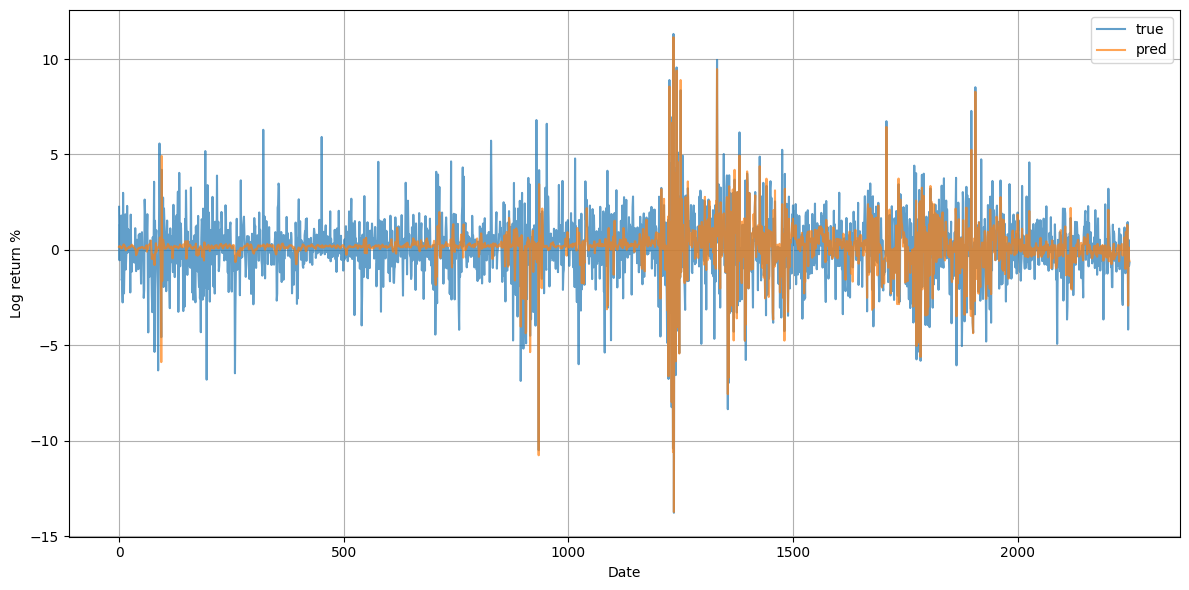

In [118]:
plt.figure(figsize=(12, 6))
plt.plot(train_true, label='true', alpha=0.7)
plt.plot(train_pred, label='pred', alpha=0.7)
plt.xlabel("Date")
plt.ylabel("Log return %")
plt.legend()
plt.tight_layout()
plt.grid(True)
plt.show()

### Test Results

Directional Accuracy: 0.4854
Confusion Matrix:
True Positive  (TP): 51
True Negative  (TN): 65
False Positive (FP): 33
False Negative (FN): 90
F1 Score: 0.4533


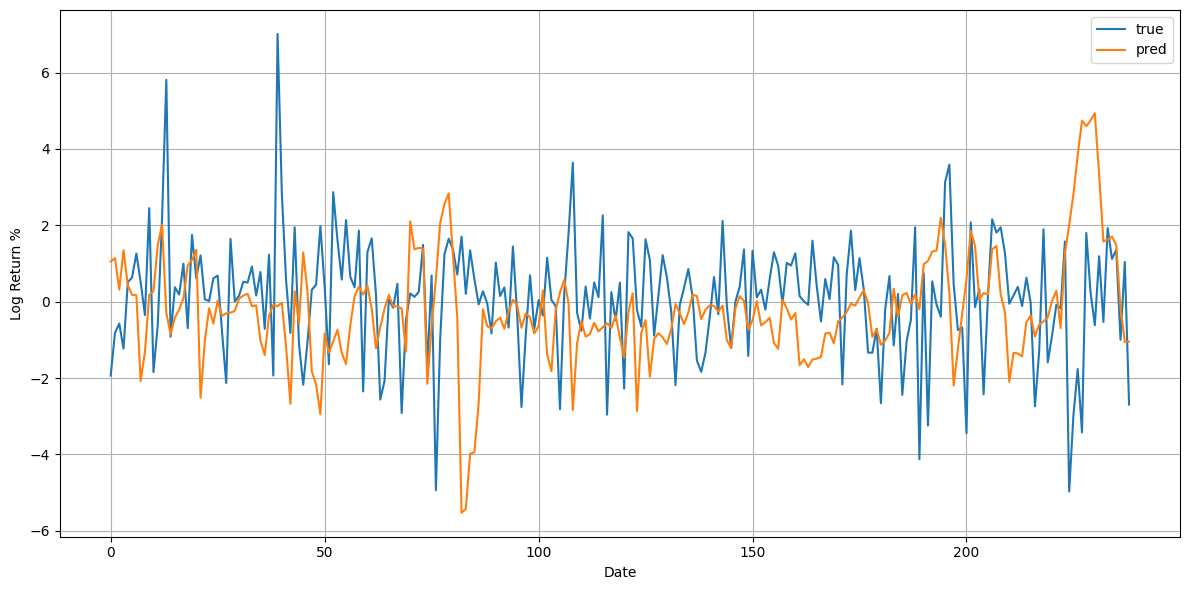

: 

In [ ]:
model.eval()
test_pred = []
test_true = []

with torch.no_grad():
    for X_test,y_test in testLoader:
        X_test = X_test.to(device)
        y_test = y_test.to(device)
        out = model(X_test).squeeze(-1)

        test_pred.extend(out.to('cpu').numpy())
        test_true.extend(y_test.to('cpu').numpy())


test_pred = np.array(test_pred)
test_true = np.array(test_true)

calc_metrics(test_true, test_pred)

plt.figure(figsize=(12, 6))
plt.plot(test_true, label='true')
plt.plot(test_pred, label='pred')
plt.xlabel("Date")
plt.ylabel("Log Return %")
plt.legend()
plt.tight_layout()
plt.grid(True)
plt.show()